<a href="https://colab.research.google.com/github/martinfinis/HelloCodeSchoolProject/blob/master/RNN_Quest_2_Martin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#beforehand

In [1]:
import glob
import cv2
import keras,os
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from keras.models import Sequential, load_model
from keras.layers import Dropout, Input, Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, AveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import numpy as np
import pandas as pd

## helper

In [2]:
def get_image_information(main_target_path,sub_path ,class_list ,data_format ):
    info_array = []#np.array([[0,8]])
    column_names = ['class_x','name_x','row','column','channel','shape','main_target_path','sub_path']

    for class_name in class_list:
        path = os.path.join(os.sep,main_target_path,sub_path,class_name)
        img_path_list = glob.glob(path + data_format)

        for img_path in img_path_list:
            img = cv2.imread(img_path)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            info_array.append([class_name,os.path.split(img_path)[-1],img.shape[0],img.shape[1],img.shape[2],img.shape,main_target_path,sub_path])

    df = pd.DataFrame(data=info_array,columns= column_names)
    return df

In [3]:
import matplotlib.pyplot as plt

def history_plot_from_loss_acc(history, title):
  plt.figure(figsize=(10,5))

  train_loss_list = history.history['loss']
  train_accuracy = history.history['accuracy']
  val_loss_list = history.history['val_loss']
  val_accuracy_list = history.history['val_accuracy']
  x = history.epoch
  
  plt.subplot(1,2,1)
  plt.plot(x, train_loss_list)
  plt.plot(x, val_loss_list)
  plt.legend(['train_loss', 'val_loss'])
  plt.title(title+"_ LOSS")
  
  plt.subplot(1,2,2)
  plt.plot(x, train_accuracy)
  plt.plot(x, val_accuracy_list)
  plt.legend(['train_acc','val_accuracy'])
  plt.title(title+"_ ACCURACY")
  plt.show()

In [4]:
def create_result_df(y_predict,test_generator):
  """
  y_predict_vgg16 = y_predict
  test_generator = generator
  sub_path = 'test

  uses function:
  get_image_information(main_target_path=main_target_path,
            sub_path='test',
            class_list=artist_list,
            data_format=data_format)

  """
  y_predict = np.argmax(y_predict, axis=-1)
  pre_file_df = pd.DataFrame(data=[y_predict,test_generator.filenames]).T
  pre_file_df.columns = ['predict','class_name']

  df_test =get_image_information(main_target_path=main_target_path,sub_path='test',class_list=artist_list,data_format=data_format)
  df_test['class_name']=df_test.apply(lambda x: (str(x.class_x)+"/"+str(x.name_x)),axis=1)
  df_test = pd.merge(df_test, pre_file_df, on=["class_name", "class_name"])
  df_test['class_value'] = df_test.class_x.map(artist_class_name_dict)
  df_test['test_result'] = df_test.apply(lambda x: x.predict == x.class_value,axis = 1)

  df_groups = df_test.groupby('class_x').agg( class_sum =('class_x','count'),test_sum =('test_result','sum')).reset_index()
  df_groups['percent_all'] = (df_groups['class_sum']/df_groups['class_sum'].sum())*100
  df_groups['percent_test'] = (df_groups['test_sum']/df_groups['class_sum'])*100
  return df_groups

In [5]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd

def plot_confusion_matrix_x(labels,predictions,classes_name):
  """
  example:
  predictions=max_predict # np.argmax(y_predict, axis=-1)
  labels=test_generator.classes
  classes_name = artist_list
  """
  con_mat = tf.math.confusion_matrix(labels=labels, predictions=np.argmax(predictions, axis=-1) ).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(con_mat_norm,index = classes_name,columns = classes_name)

  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [6]:
import glob
data_format = '/*.jpg'

def number_of_images_in_path(target_path,data_format):
    print(target_path)
    img_path_list = glob.glob(target_path + data_format)
           
    n = len(img_path_list)
    print(f'Number of images: {n}\n')



In [7]:
def organize_by_crop_center_train_test_vaildation_dir(main_target_path,all_subdir,class_list,data_format,ml_subdir_list,train_size,test_size,validation_size):
    """
    :param main_target_path:
    :param all_subdir:
    :param class_list:
    :param data_format:
    :param ml_subdir_list:
    :param train_size:
    :param test_size:
    :param validation_size:
    :return:
    """
    assert(train_size+test_size+validation_size == 1)

    for ml_subdir in ml_subdir_list:
        if not os.path.exists(os.path.join(main_target_path, ml_subdir)):
            os.makedirs(os.path.join(main_target_path, ml_subdir))

    for class_name in class_list:
        img_path_list =  number_of_images_in_path(os.path.join(os.sep,main_target_path,all_subdir,class_name),data_format)

        #shuffle
        np.random.shuffle(img_path_list)
        #create class_dir
        for ml_subdir in ml_subdir_list:
            if not os.path.exists(os.path.join(main_target_path,ml_subdir,class_name)):
                os.makedirs(os.path.join(main_target_path,ml_subdir,class_name))

        #move images to class subdir
        train_stop = int(len(img_path_list) * train_size)
        validation_stop = train_stop + int(len(img_path_list) * validation_size)
        test_stop = validation_stop + int(len(img_path_list) * test_size)

        print(len(img_path_list))
        print(str(train_stop + validation_stop + test_stop))

        n = 0
        m = 0

        for imp_path in img_path_list:
            new_filepath = ''
            new_name = os.path.split(img_path_list[n])[-1]
            new_name_x = new_name[:-4]+"_center_"+str(m)+new_name[-4:]
            m += 1
            if n <= train_stop:
                new_filepath = os.path.join(main_target_path, ml_subdir_list[0], class_name, new_name_x)
            elif n <= validation_stop:
                new_filepath = os.path.join(main_target_path, ml_subdir_list[1], class_name, new_name_x)
            elif n <= test_stop:
                new_filepath = os.path.join(main_target_path, ml_subdir_list[2], class_name, new_name_x)
            else:
                print(f"this should nerver happen .... n={n}")
                new_filepath = os.path.join(main_target_path, ml_subdir_list[2], class_name, new_name_x)

            source = img_path_list[n]
            target = new_filepath
            #print(f"source {source}")
            #print(f"target {target}")
            try:
                image = cv2.imread(source)
                image = get_center_crop(image)
                cv2.imwrite(target, image)
            except Error as e:
                print("Unable to copy file. %s" % e)

            n += 1

In [8]:
def organize_by_crop_random_train_test_vaildation_dir(main_target_path,all_subdir,class_list,data_format,ml_subdir_list,train_size,test_size,validation_size,m = 0):
    """
    :param main_target_path:
    :param all_subdir:
    :param class_list:
    :param data_format:
    :param ml_subdir_list:
    :param train_size:
    :param test_size:
    :param validation_size:
    :return:
    """
    assert(train_size+test_size+validation_size == 1)

    for ml_subdir in ml_subdir_list:
        if not os.path.exists(os.path.join(main_target_path, ml_subdir)):
            os.makedirs(os.path.join(main_target_path, ml_subdir))

    for class_name in class_list:
        img_path_list =  number_of_images_in_path(os.path.join(os.sep,main_target_path,all_subdir,class_name),data_format)

        #shuffle
        np.random.shuffle(img_path_list)
        #create class_dir
        for ml_subdir in ml_subdir_list:
            if not os.path.exists(os.path.join(main_target_path,ml_subdir,class_name)):
                os.makedirs(os.path.join(main_target_path,ml_subdir,class_name))

        #move images to class subdir
        train_stop = int(len(img_path_list) * train_size)
        validation_stop = train_stop + int(len(img_path_list) * validation_size)
        test_stop = validation_stop + int(len(img_path_list) * test_size)

        print(len(img_path_list))
        print(str(train_stop + validation_stop + test_stop))

        n = 0

        for imp_path in img_path_list:
            new_filepath = ''
            new_name = os.path.split(img_path_list[n])[-1]
            new_name_x = new_name[:-4]+"_ramdom_"+str(m)+new_name[-4:]
            m += 1
            if n <= train_stop:
                new_filepath = os.path.join(main_target_path, ml_subdir_list[0], class_name, new_name_x)
            elif n <= validation_stop:
                new_filepath = os.path.join(main_target_path, ml_subdir_list[1], class_name, new_name_x)
            elif n <= test_stop:
                new_filepath = os.path.join(main_target_path, ml_subdir_list[2], class_name, new_name_x)
            else:
                print(f"this should nerver happen .... n={n}")
                new_filepath = os.path.join(main_target_path, ml_subdir_list[2], class_name, new_name_x)

            source = img_path_list[n]
            target = new_filepath
            #print(f"source {source}")
            #print(f"target {target}")
            try:
                image = cv2.imread(source)
                if (image.shape[0] > 220) and (image.shape[0] > 220):
                    image = get_random_crop(image)
                    cv2.imwrite(target, image)
                else:
                    print(f"Image size to small {image.shape} {source}")
            except ValueError as ve:
                print("ValueError",ve)
            except Error as e:
                print("Unable to copy file",e)

            n += 1


#import data

In [9]:
# mount google drive to access dataset
from google.colab import drive
drive.mount('/content/drive')
# change directory
%cd /content/
# create new local directory, i.e. on the current machine which you are connected to
!mkdir local_data   # could also be another name than local_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
mkdir: cannot create directory ‘local_data’: File exists


In [10]:
!unzip '/content/drive/MyDrive/Copy_Material_AIDA_2021/_spec_ML3_wolfgang/Week_3/Fabritius.zip' -d local_data

Archive:  /content/drive/MyDrive/Copy_Material_AIDA_2021/_spec_ML3_wolfgang/Week_3/Fabritius.zip
   creating: local_data/Fabritius/
  inflating: local_data/Fabritius/Fabritius-07b496b2-45df-bb00-1cf7-d3fb4c2d86bd.jpg  
  inflating: local_data/Fabritius/Fabritius-0ca97c0f-0f59-3370-33df-a531586495fc.jpg  
  inflating: local_data/Fabritius/Fabritius-0ce70c8a-73ad-ec04-f3ed-f827b646fc8d.jpg  
  inflating: local_data/Fabritius/Fabritius-2cab5351-287d-7099-60fa-daa15e40198a.jpg  
  inflating: local_data/Fabritius/Fabritius-681989e7-0a85-5c57-3095-ed1c8467c504.jpg  
  inflating: local_data/Fabritius/Fabritius-7177f114-68cb-ee84-3499-28f05c4d4b5a.jpg  
  inflating: local_data/Fabritius/Fabritius-751cbee6-8c89-379c-ca89-6590a65ef122.jpg  
  inflating: local_data/Fabritius/Fabritius-7de95bd0-e9de-c583-d928-fbf280010e28.jpg  
  inflating: local_data/Fabritius/Fabritius-7eb4c472-f33c-8d27-06c3-ecde457866fe.jpg  
  inflating: local_data/Fabritius/Fabritius-8d0fa950-b9f8-6eff-8956-0a4272259554.jpg 

In [11]:
!unzip '/content/drive/MyDrive/Copy_Material_AIDA_2021/_spec_ML3_wolfgang/Week_3/resized.zip' -d local_data

Archive:  /content/drive/MyDrive/Copy_Material_AIDA_2021/_spec_ML3_wolfgang/Week_3/resized.zip
 extracting: local_data/resized/Albrecht_DuтХа├кrer_1.jpg  
 extracting: local_data/resized/Albrecht_DuтХа├кrer_10.jpg  
 extracting: local_data/resized/Albrecht_DuтХа├кrer_100.jpg  
  inflating: local_data/resized/Albrecht_DuтХа├кrer_101.jpg  
  inflating: local_data/resized/Albrecht_DuтХа├кrer_102.jpg  
  inflating: local_data/resized/Albrecht_DuтХа├кrer_103.jpg  
 extracting: local_data/resized/Albrecht_DuтХа├кrer_104.jpg  
  inflating: local_data/resized/Albrecht_DuтХа├кrer_105.jpg  
 extracting: local_data/resized/Albrecht_DuтХа├кrer_106.jpg  
 extracting: local_data/resized/Albrecht_DuтХа├кrer_107.jpg  
 extracting: local_data/resized/Albrecht_DuтХа├кrer_108.jpg  
 extracting: local_data/resized/Albrecht_DuтХа├кrer_109.jpg  
  inflating: local_data/resized/Albrecht_DuтХа├кrer_11.jpg  
  inflating: local_data/resized/Albrecht_DuтХа├кrer_110.jpg  
 extracting: local_data/resized/Albrecht_

In [12]:
cd /content/

/content


In [13]:
#!mkdir training_set
#!mkdir test_set

In [14]:
#ls -l

In [15]:
#rm -r ./best_model_simple/

In [16]:
#/content/local_data/resized
#data_path = 'C:/_dev/_aida/scientificProject/data/w_3/resized'
data_path = '/content/local_data/resized'

#/content/local_data/
#main_target_path = 'C:\\_dev\\_aida\\scientificProject\\data\\w_3\\'
main_target_path = '/content/local_data'


all_subdir = 'data_set'
train_subdir = 'train'
val_subdir = 'valid'
test_subdir = 'test'

train_size = 0.7
val_size = 0.15
test_size = 0.15

artist_list = ['Albrecht_Duerer','Caravaggio','Fabritius','Giotto_di_Bondone','Leonardo_da_Vinci','Michelangelo','Raphael','Rembrandt']
#artist_list = ['Albrecht_Duerer','Caravaggio','Giotto_di_Bondone','Leonardo_da_Vinci','Michelangelo','Raphael','Rembrandt']
data_format = '/*.jpg'


In [17]:
artist_name_class_dict = { i : artist_list[i] for i in range(0, len(artist_list) ) }
artist_class_name_dict = { artist_list[i] : i for i in range(0, len(artist_list) ) }

In [18]:
artist_class_name_dict

{'Albrecht_Duerer': 0,
 'Caravaggio': 1,
 'Fabritius': 2,
 'Giotto_di_Bondone': 3,
 'Leonardo_da_Vinci': 4,
 'Michelangelo': 5,
 'Raphael': 6,
 'Rembrandt': 7}

## import and organize images

In [19]:
for file_name in listdir(data_path):
    #print(file_name)

    #convert Albrecht_DuÔòá├¬rer
    if file_name.startswith('Albrecht_DuтХа├кrer'):
        new_file_name = file_name.replace('Albrecht_DuтХа├кrer','Albrecht_Duerer_x')
    elif file_name.startswith('Albrecht_Du╠Иrer'):
        new_file_name = file_name.replace('Albrecht_Du╠Иrer','Albrecht_Duerer_y')
    else:
        new_file_name = file_name

    for artist_name in artist_list:
        if new_file_name.startswith(artist_name):
            filepath = os.path.join(data_path,file_name)
            new_filepath = os.path.join(main_target_path,all_subdir,artist_name,new_file_name)

            #check dir and create
            if not os.path.exists(os.path.join(main_target_path,all_subdir,artist_name)):
                os.makedirs(os.path.join(main_target_path,all_subdir,artist_name))
            #move file
            try:
                os.rename(filepath, new_filepath)
            except:
                continue

In [20]:
!mv /content/local_data/Fabritius /content/local_data/data_set

mv: cannot move '/content/local_data/Fabritius' to '/content/local_data/data_set/Fabritius': Directory not empty


In [21]:
for artist_name in artist_list:
    number_of_images_in_path(os.path.join(os.sep,main_target_path,all_subdir,artist_name),data_format)

/content/local_data/data_set/Albrecht_Duerer
Number of images: 656

/content/local_data/data_set/Caravaggio
Number of images: 55

/content/local_data/data_set/Fabritius
Number of images: 17

/content/local_data/data_set/Giotto_di_Bondone
Number of images: 119

/content/local_data/data_set/Leonardo_da_Vinci
Number of images: 143

/content/local_data/data_set/Michelangelo
Number of images: 49

/content/local_data/data_set/Raphael
Number of images: 109

/content/local_data/data_set/Rembrandt
Number of images: 262



## orginze in train,test and validate

In [22]:
from shutil import copyfile
from sys import exit

all_subdir = 'data_set'
train_subdir = 'normal/train'
val_subdir = 'normal/validation'
test_subdir = 'normal/test'

train_size = 0.7
val_size = 0.15
test_size = 0.15

def number_of_images_in_path(target_path,data_format):
    print(target_path)
    img_path_list = glob.glob(target_path + data_format)

    n = len(img_path_list)
    print(f'Number of images: {n}\n')
    return img_path_list

def organize_by_copy_train_test_vaildation_dir(main_target_path,all_subdir,class_list,data_format,ml_subdir_list,train_size,test_size,validation_size):
    """
    :param main_target_path:
    :param all_subdir:
    :param class_list:
    :param data_format:
    :param ml_subdir_list:
    :param train_size:
    :param test_size:
    :param validation_size:
    :return:
    """
    assert(train_size+test_size+validation_size == 1)

    for ml_subdir in ml_subdir_list:
        if not os.path.exists(os.path.join(main_target_path, ml_subdir)):
            os.makedirs(os.path.join(main_target_path, ml_subdir))

    for class_name in class_list:
        img_path_list =  number_of_images_in_path(os.path.join(os.sep,main_target_path,all_subdir,class_name),data_format)

        #shuffle
        np.random.shuffle(img_path_list)
        #create class_dir
        for ml_subdir in ml_subdir_list:
            if not os.path.exists(os.path.join(main_target_path,ml_subdir,class_name)):
                os.makedirs(os.path.join(main_target_path,ml_subdir,class_name))

        #move images to class subdir
        train_stop = int(len(img_path_list) * train_size)
        validation_stop = train_stop + int(len(img_path_list) * validation_size)
        test_stop = validation_stop + int(len(img_path_list) * test_size)

        n = 0
        for imp_path in img_path_list:
            new_filepath = ''
            if n <= train_stop:
                new_filepath = os.path.join(main_target_path, ml_subdir_list[0], class_name, os.path.split(img_path_list[n])[-1])
            elif n <= validation_stop:
                new_filepath = os.path.join(main_target_path, ml_subdir_list[1], class_name, os.path.split(img_path_list[n])[-1])
            elif n <= test_stop:
                new_filepath = os.path.join(main_target_path, ml_subdir_list[2], class_name, os.path.split(img_path_list[n])[-1])
            else:
                print(f"this should nerver happen .... n={n}")
                new_filepath = os.path.join(main_target_path, ml_subdir_list[2], class_name, os.path.split(img_path_list[n])[-1])    

            # copy file
            source = img_path_list[n]
            target = new_filepath

            try:
                copyfile(source, target)
                n += 1
            except IOError as e:
                print("Unable to copy file. %s" % e)
                continue


organize_by_copy_train_test_vaildation_dir(main_target_path=main_target_path,all_subdir=all_subdir,
                                   class_list=artist_list,data_format=data_format,
                                   ml_subdir_list=[train_subdir,val_subdir,test_subdir],
                                   train_size=train_size,
                                   validation_size=val_size,
                                   test_size=test_size)

/content/local_data/data_set/Albrecht_Duerer
Number of images: 656

/content/local_data/data_set/Caravaggio
Number of images: 55

/content/local_data/data_set/Fabritius
Number of images: 17

this should nerver happen .... n=16
/content/local_data/data_set/Giotto_di_Bondone
Number of images: 119

this should nerver happen .... n=118
/content/local_data/data_set/Leonardo_da_Vinci
Number of images: 143

/content/local_data/data_set/Michelangelo
Number of images: 49

/content/local_data/data_set/Raphael
Number of images: 109

/content/local_data/data_set/Rembrandt
Number of images: 262



# begin with VGG16

Let's improve our painter classifier! It's always a good idea to look at how other people have tackled a problem. 

Here are some links: 

http://cs231n.stanford.edu/reports/2017/pdfs/406.pdf

http://cs231n.stanford.edu/reports/2017/pdfs/410.pdf






https://github.com/keras-team/keras/issues/3338

##1- add Carel Fabritius

I also want you to implement another painter into your dataset - Carel Fabritius, a scolar of Rembrandt. The reason is, that there are only 17 paintings of Fabritius left. Let's (along with other things) see how our model performs on such a small class. 

In [23]:
in_shape = (224,224,3)

In [24]:
train_gen = ImageDataGenerator(rescale=1./255.)
validation_gen = ImageDataGenerator(rescale=1./255.)
test_gen = ImageDataGenerator(rescale=1./255.)

In [25]:
train_generator = train_gen.flow_from_directory(directory="/content/local_data/normal/train",target_size=(224,224),batch_size=16,shuffle=True,seed=42)
valid_generator = validation_gen.flow_from_directory(directory="/content/local_data/normal/validation",target_size=(224,224),batch_size=16,shuffle=False,seed=42)
test_generator = test_gen.flow_from_directory(directory="/content/local_data/normal/test", target_size=(224,224),batch_size=16,shuffle=False,seed=42)

Found 1289 images belonging to 8 classes.
Found 388 images belonging to 8 classes.
Found 384 images belonging to 8 classes.


In [26]:
import tensorflow. keras as keras
vgg16_model = keras.applications.VGG16()

In [27]:
vgg16_model = keras.applications.vgg16.VGG16(
  weights='imagenet',
  include_top=False,
  input_shape=in_shape)

# freeze the weights
vgg16_model.trainable = False

In [28]:
model_vgg16_c = Sequential()
for layer in vgg16_model.layers:
  model_vgg16_c.add(layer)

In [29]:
for layer in model_vgg16_c.layers:
  layer.trainable = False

In [30]:
model_vgg16_c.add(Flatten())
model_vgg16_c.add(Dense(256,activation='relu'))
model_vgg16_c.add(Dropout(0.5))
model_vgg16_c.add(Dense(8,activation='softmax'))
model_vgg16_c.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [32]:
model_vgg16_c.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics='accuracy') 

In [33]:
mcp_2 = ModelCheckpoint('keras_applications_VGG16', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [34]:
history_model_vgg16_c = model_vgg16_c.fit(train_generator,validation_data = valid_generator,epochs=30,callbacks=[mcp_2])    

Epoch 1/30
81/81 [==============================] - 31s 300ms/step - loss: 1.4301 - accuracy: 0.5453 - val_loss: 0.5215 - val_accuracy: 0.8325

Epoch 00001: val_accuracy improved from -inf to 0.83247, saving model to keras_applications_VGG16
INFO:tensorflow:Assets written to: keras_applications_VGG16/assets
Epoch 2/30
81/81 [==============================] - 19s 239ms/step - loss: 0.5953 - accuracy: 0.8001 - val_loss: 0.3966 - val_accuracy: 0.8557

Epoch 00002: val_accuracy improved from 0.83247 to 0.85567, saving model to keras_applications_VGG16
INFO:tensorflow:Assets written to: keras_applications_VGG16/assets
Epoch 3/30
81/81 [==============================] - 19s 234ms/step - loss: 0.4175 - accuracy: 0.8763 - val_loss: 0.2699 - val_accuracy: 0.9253

Epoch 00003: val_accuracy improved from 0.85567 to 0.92526, saving model to keras_applications_VGG16
INFO:tensorflow:Assets written to: keras_applications_VGG16/assets
Epoch 4/30
81/81 [==============================] - 19s 235ms/step 

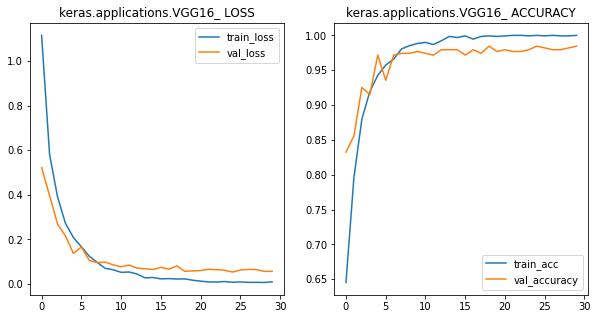

In [35]:
history_plot_from_loss_acc(history_model_vgg16_c,'keras.applications.VGG16')

In [36]:
best_keras_applications_VGG16_model = load_model('keras_applications_VGG16')

#### result

In [37]:
y_eval = best_keras_applications_VGG16_model.evaluate(test_generator)

24/24 [==============================] - 5s 174ms/step - loss: 0.0720 - accuracy: 0.9766


In [38]:
y_predict_vgg16_model = best_keras_applications_VGG16_model.predict(test_generator)

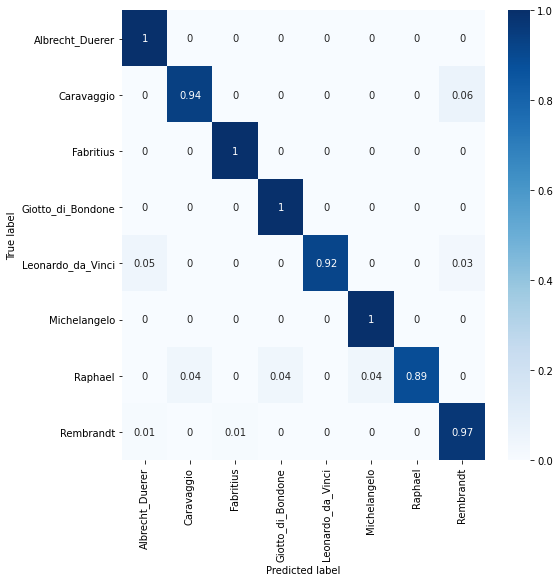

In [39]:
plot_confusion_matrix_x(test_generator.classes,y_predict_vgg16_model,artist_list)

In [40]:
#create_result_df(y_predict_vgg16_model,test_generator)

##2- use only crop samples

Now restructure your dataset so that you can implement Nitin Vishwanathans approach: Take one center crop and one random crop of each image. To do so, you need to write two functions, one to get a center crop of your image dimensions and one to get a random crop. 

### crop

 inspired from

https://jkjung-avt.github.io/keras-image-cropping/

https://gist.github.com/rstml/bbd491287efc24133b90d4f7f3663905

### orginze in train,test and validate

In [41]:
def get_center_crop(img):
  dy = 224
  dx = 224

  height, width = img.shape[0], img.shape[1]
   
  x = (width - dx + 1) // 2
  y = (height - dy + 1) // 2
  return img[y:(y+dy), x:(x+dx), :]

In [42]:
def get_random_crop(img):
  height, width = img.shape[0], img.shape[1]
 
  dy = 224
  dx = 224
  x = np.random.randint(0, width - dx + 1)
  y = np.random.randint(0, height - dy + 1)
  return img[y:(y+dy), x:(x+dx), :]

In [43]:
from shutil import copyfile
from sys import exit

all_subdir = 'data_set'
train_subdir = 'crop_1/train'
val_subdir = 'crop_1/validation'
test_subdir = 'crop_1/test'

train_size = 0.7
val_size = 0.15
test_size = 0.15

organize_by_crop_center_train_test_vaildation_dir(main_target_path=main_target_path,all_subdir=all_subdir,
                                   class_list=artist_list,data_format=data_format,
                                   ml_subdir_list=[train_subdir,val_subdir,test_subdir],
                                   train_size=train_size,
                                   validation_size=val_size,
                                   test_size=test_size)

/content/local_data/data_set/Albrecht_Duerer
Number of images: 656

656
1671
/content/local_data/data_set/Caravaggio
Number of images: 55

55
138
/content/local_data/data_set/Fabritius
Number of images: 17

17
39
this should nerver happen .... n=16
/content/local_data/data_set/Giotto_di_Bondone
Number of images: 119

119
300
this should nerver happen .... n=118
/content/local_data/data_set/Leonardo_da_Vinci
Number of images: 143

143
363
/content/local_data/data_set/Michelangelo
Number of images: 49

49
123
/content/local_data/data_set/Raphael
Number of images: 109

109
276
/content/local_data/data_set/Rembrandt
Number of images: 262

262
666


In [44]:
organize_by_crop_random_train_test_vaildation_dir(main_target_path=main_target_path,all_subdir=all_subdir,
                                   class_list=artist_list,data_format=data_format,
                                   ml_subdir_list=[train_subdir,val_subdir,test_subdir],
                                   train_size=train_size,
                                   validation_size=val_size,
                                   test_size=test_size)

/content/local_data/data_set/Albrecht_Duerer
Number of images: 656

656
1671
/content/local_data/data_set/Caravaggio
Number of images: 55

55
138
/content/local_data/data_set/Fabritius
Number of images: 17

17
39
this should nerver happen .... n=16
/content/local_data/data_set/Giotto_di_Bondone
Number of images: 119

119
300
this should nerver happen .... n=118
/content/local_data/data_set/Leonardo_da_Vinci
Number of images: 143

143
363
ValueError low >= high
/content/local_data/data_set/Michelangelo
Number of images: 49

49
123
/content/local_data/data_set/Raphael
Number of images: 109

109
276
Image size to small (174, 614, 3) /content/local_data/data_set/Raphael/Raphael_35.jpg
/content/local_data/data_set/Rembrandt
Number of images: 262

262
666


NOTE: you would not necessarily need to restructure the data set - if you wrote a custom data_generator who does the cropping for you. And check whether keras has this under the hood. But you might be unlucky...

###feed them with the crops

Now take the models from RNN_Quest_1 - and feed them with the crops, rather than the resized images!

What is the performance? Did it improve? 

In [45]:
train_gen = ImageDataGenerator(rescale=1./255.)
validation_gen = ImageDataGenerator(rescale=1./255.)
test_gen = ImageDataGenerator(rescale=1./255.)

In [46]:
train_generator = train_gen.flow_from_directory(directory="/content/local_data/crop_1/train",target_size=(224,224),batch_size=16,shuffle=True,seed=42)
valid_generator = validation_gen.flow_from_directory(directory="/content/local_data/crop_1/validation",target_size=(224,224),batch_size=16,shuffle=False,seed=42)
test_generator = test_gen.flow_from_directory(directory="/content/local_data/crop_1/test", target_size=(224,224),batch_size=16,shuffle=False,seed=42)

Found 3957 images belonging to 8 classes.
Found 830 images belonging to 8 classes.
Found 837 images belonging to 8 classes.


In [47]:
vgg16_model = keras.applications.vgg16.VGG16(
  weights='imagenet',
  include_top=False,
  input_shape=in_shape)

# freeze the weights
vgg16_model.trainable = False

In [48]:
model_vgg16_d = Sequential()
for layer in vgg16_model.layers:
  model_vgg16_d.add(layer)

In [49]:
for layer in model_vgg16_d.layers:
  layer.trainable = False

In [50]:
model_vgg16_d.add(Flatten())
model_vgg16_d.add(Dense(256,activation='relu'))
model_vgg16_d.add(Dropout(0.5))
model_vgg16_d.add(Dense(8,activation='softmax'))
model_vgg16_d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [51]:
model_vgg16_d.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics='accuracy') 

In [52]:
mcp_2 = ModelCheckpoint('keras_applications_VGG16', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [53]:
history_model_vgg16_d = model_vgg16_d.fit(train_generator,validation_data = valid_generator,epochs=30,callbacks=[mcp_2])    

Epoch 1/30
248/248 [==============================] - 48s 188ms/step - loss: 1.2659 - accuracy: 0.5905 - val_loss: 0.6192 - val_accuracy: 0.8084

Epoch 00001: val_accuracy improved from -inf to 0.80843, saving model to keras_applications_VGG16
INFO:tensorflow:Assets written to: keras_applications_VGG16/assets
Epoch 2/30
248/248 [==============================] - 40s 160ms/step - loss: 0.6330 - accuracy: 0.7900 - val_loss: 0.5777 - val_accuracy: 0.8205

Epoch 00002: val_accuracy improved from 0.80843 to 0.82048, saving model to keras_applications_VGG16
INFO:tensorflow:Assets written to: keras_applications_VGG16/assets
Epoch 3/30
248/248 [==============================] - 40s 160ms/step - loss: 0.4727 - accuracy: 0.8490 - val_loss: 0.4420 - val_accuracy: 0.8783

Epoch 00003: val_accuracy improved from 0.82048 to 0.87831, saving model to keras_applications_VGG16
INFO:tensorflow:Assets written to: keras_applications_VGG16/assets
Epoch 4/30
248/248 [==============================] - 40s 160

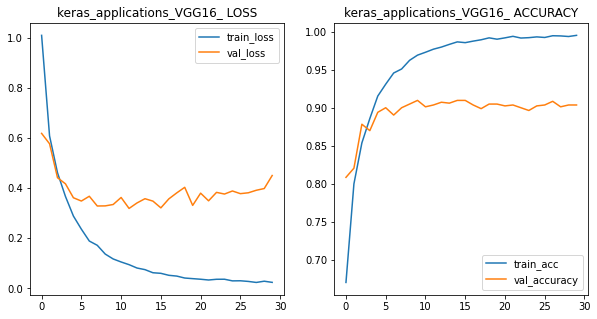

In [54]:
history_plot_from_loss_acc(history_model_vgg16_d,'keras_applications_VGG16')

In [55]:
best_keras_applications_VGG16_model = load_model('keras_applications_VGG16')

### result

In [56]:
y_eval = best_keras_applications_VGG16_model.evaluate(test_generator)

53/53 [==============================] - 7s 130ms/step - loss: 0.3693 - accuracy: 0.8817


In [57]:
y_predict_vgg16_model = best_keras_applications_VGG16_model.predict(test_generator)

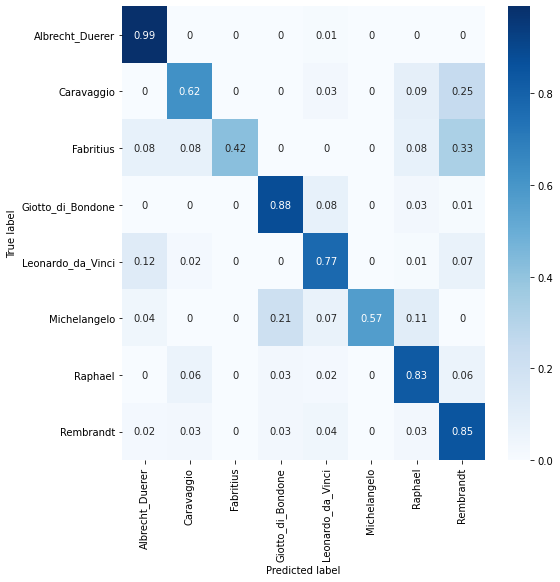

In [58]:
plot_confusion_matrix_x(test_generator.classes,y_predict_vgg16_model,artist_list)

In [59]:
pred = np.argmax(abs(y_predict_vgg16_model), axis=1)

In [60]:
from sklearn.metrics import classification_report
report = classification_report(test_generator.classes, pred, target_names=test_generator.class_indices)
print(report)

                   precision    recall  f1-score   support

  Albrecht_Duerer       0.96      0.99      0.97       391
       Caravaggio       0.62      0.62      0.62        32
        Fabritius       1.00      0.42      0.59        12
Giotto_di_Bondone       0.83      0.88      0.85        72
Leonardo_da_Vinci       0.75      0.77      0.76        83
     Michelangelo       1.00      0.57      0.73        28
          Raphael       0.78      0.83      0.80        63
        Rembrandt       0.85      0.85      0.85       156

         accuracy                           0.88       837
        macro avg       0.85      0.74      0.77       837
     weighted avg       0.88      0.88      0.88       837



In [61]:
report_dict = classification_report(test_generator.classes, pred, target_names=test_generator.class_indices,output_dict=True)

In [62]:
for artist_name in artist_list:
    number_of_images_in_path(os.path.join(os.sep,main_target_path,"crop_1/test",artist_name),data_format)
    
df =get_image_information(main_target_path=main_target_path,sub_path="crop_1/test",class_list=artist_list,data_format=data_format)

/content/local_data/crop_1/test/Albrecht_Duerer
Number of images: 391

/content/local_data/crop_1/test/Caravaggio
Number of images: 32

/content/local_data/crop_1/test/Fabritius
Number of images: 12

/content/local_data/crop_1/test/Giotto_di_Bondone
Number of images: 72

/content/local_data/crop_1/test/Leonardo_da_Vinci
Number of images: 83

/content/local_data/crop_1/test/Michelangelo
Number of images: 28

/content/local_data/crop_1/test/Raphael
Number of images: 63

/content/local_data/crop_1/test/Rembrandt
Number of images: 156



In [63]:
df_group = df.groupby('class_x').agg(all=('class_x','count')).reset_index()

In [64]:
df_group['perc']=df_group['all'].apply(lambda x: x/df.shape[0]*100)

In [65]:
df_group['f1-score'] =  df_group['class_x'].map(lambda x:report_dict.get(x).get('f1-score'))

In [66]:
df_group['precision'] =  df_group['class_x'].map(lambda x:report_dict.get(x).get('precision'))

In [67]:
df_group.sort_values(by=['precision'],ascending=False)

,class_x,all,perc,f1-score,precision
2,Fabritius,12,1.433692,0.588235,1.000000
5,Michelangelo,28,3.345281,0.727273,1.000000
0,Albrecht_Duerer,391,46.714456,0.974747,0.962594
7,Rembrandt,156,18.637993,0.848875,0.851613
3,Giotto_di_Bondone,72,8.602151,0.851351,0.828947
6,Raphael,63,7.526882,0.800000,0.776119
4,Leonardo_da_Vinci,83,9.916368,0.761905,0.752941
1,Caravaggio,32,3.823178,0.625000,0.625000


In [68]:
df_group.sort_values(by=['f1-score'],ascending=False)

,class_x,all,perc,f1-score,precision
0,Albrecht_Duerer,391,46.714456,0.974747,0.962594
3,Giotto_di_Bondone,72,8.602151,0.851351,0.828947
7,Rembrandt,156,18.637993,0.848875,0.851613
6,Raphael,63,7.526882,0.800000,0.776119
4,Leonardo_da_Vinci,83,9.916368,0.761905,0.752941
5,Michelangelo,28,3.345281,0.727273,1.000000
1,Caravaggio,32,3.823178,0.625000,0.625000
2,Fabritius,12,1.433692,0.588235,1.000000


#compare VGG16 with resnet 50

### RESNET 50

#### top model

In [69]:
from keras.models import Model
from keras import initializers
from keras.applications.resnet50 import ResNet50

In [70]:
resnet50 = ResNet50(include_top=False, input_shape=in_shape)

In [71]:
dropout_rate = 0.3
num_classes = 8

# Top Model
a = Input(shape=(7,7,2048))
x = AveragePooling2D(7,7)(a)
x = Flatten()(x)
x = Dropout(dropout_rate)(x)
x = Dense(2048, kernel_initializer=initializers.he_normal(), bias_initializer=initializers.ones(),activation='relu')(x)
x = Dense(num_classes, kernel_initializer=initializers.he_normal(), bias_initializer=initializers.ones(), activation='softmax')(x)
top_model = Model(inputs=a, outputs=x)

#top_model.summary()

In [72]:
inp = Input(shape=in_shape)
y = resnet50(inp)
y = top_model(y)
final_model_resnet = Model(inp,y)

final_model_resnet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
model (Functional)           (None, 8)                 4212744   
Total params: 27,800,456
Trainable params: 27,747,336
Non-trainable params: 53,120
_________________________________________________________________


In [73]:
final_model_resnet.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics='accuracy') 

In [74]:
mcp = ModelCheckpoint('final_model_resnet', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [75]:
history_final_model_resnet = final_model_resnet.fit(train_generator,validation_data = valid_generator,epochs=25,callbacks=[mcp])    

Epoch 1/25
248/248 [==============================] - 113s 420ms/step - loss: 0.8637 - accuracy: 0.7576 - val_loss: 6.3912 - val_accuracy: 0.0518

Epoch 00001: val_accuracy improved from -inf to 0.05181, saving model to final_model_resnet
INFO:tensorflow:Assets written to: final_model_resnet/assets
Epoch 2/25
248/248 [==============================] - 101s 406ms/step - loss: 0.1383 - accuracy: 0.9516 - val_loss: 8.8579 - val_accuracy: 0.0940

Epoch 00002: val_accuracy improved from 0.05181 to 0.09398, saving model to final_model_resnet
INFO:tensorflow:Assets written to: final_model_resnet/assets
Epoch 3/25
248/248 [==============================] - 101s 406ms/step - loss: 0.1261 - accuracy: 0.9583 - val_loss: 2.5907 - val_accuracy: 0.5578

Epoch 00003: val_accuracy improved from 0.09398 to 0.55783, saving model to final_model_resnet
INFO:tensorflow:Assets written to: final_model_resnet/assets
Epoch 4/25
248/248 [==============================] - 101s 406ms/step - loss: 0.0875 - accurac

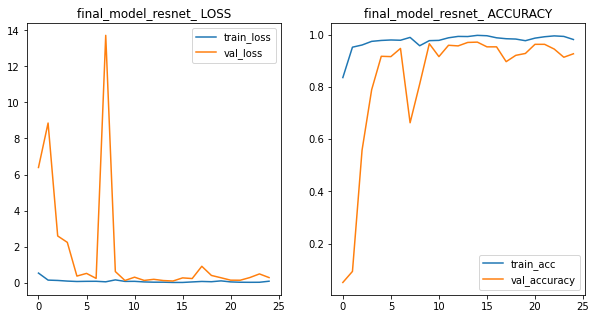

In [76]:
history_plot_from_loss_acc(history_final_model_resnet,'final_model_resnet')

In [77]:
best_final_model = load_model('final_model_resnet')

#### result

In [78]:
best_final_model.evaluate(test_generator)

53/53 [==============================] - 8s 126ms/step - loss: 0.1047 - accuracy: 0.9701


[0.10470417886972427, 0.9701313972473145]

In [79]:
y_predict_resnet_au = best_final_model.predict(test_generator)

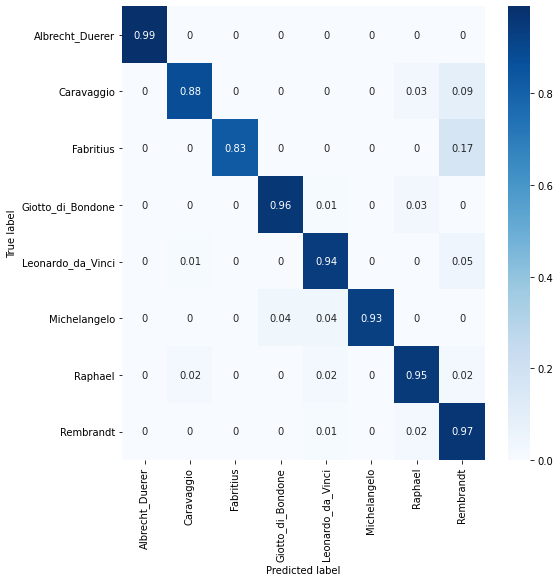

In [80]:
plot_confusion_matrix_x(test_generator.classes,y_predict_resnet_au,artist_list)

#Rethink the data preprocessing procedure

Rethink the data preprocessing procedure. You missed a great chance (and so did Vishwanathan)! What could it be.

Really DO think about it - and when you have (or maybe haven't despite trying hard) came up with a solution, go to RNN_Quest_3!

The image with the highest number of samples gets the best classification result and the image with the lowest number of samples the worst. But in between the order doesn’t follow this rule. In general you need a particular number of image classes to get a good training result, but there are also other reasons like the painter styles and distribution of this kind of style between other painters and so on. For example  Raphael style is under these circumstances easier to classify as others.